[get_dataset_dir] Dataset found in /home/ad3adha/nilearn_data/basc_multiscale_2015


/tmp/ipykernel_41617/1372470691.py:94: FutureWarning:

From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.

/home/ad3adha/datalad-env/lib/python3.12/site-packages/nilearn/signal.py:264: UserWarning:

Detrending of 3D signal has been requested but would lead to zero values. Skipping.

/home/ad3adha/datalad-env/lib/python3.12/site-packages/nilearn/signal.py:77: UserWarning:

Standardization of 3D signal has been requested but would lead to zero values. Skipping.

/tmp/ipykernel_41617/1372470691.py:94: FutureWarning:

From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.

/tmp/ipykernel_41617/1372470691.py:94:


Saving mean images per run...
  Mean image plot for sub-01 run 1 cached, skipping
  Mean image plot for sub-01 run 2 cached, skipping
  Mean image plot for sub-01 run 3 cached, skipping
  Mean image plot for sub-01 run 4 cached, skipping
  Mean image plot for sub-01 run 5 cached, skipping
  Mean image plot for sub-02 run 1 cached, skipping
  Mean image plot for sub-02 run 2 cached, skipping
  Mean image plot for sub-02 run 3 cached, skipping
  Mean image plot for sub-02 run 4 cached, skipping
  Mean image plot for sub-02 run 5 cached, skipping
  Mean image plot for sub-03 run 1 cached, skipping
  Mean image plot for sub-03 run 2 cached, skipping
  Mean image plot for sub-03 run 3 cached, skipping
  Mean image plot for sub-03 run 4 cached, skipping
  Mean image plot for sub-03 run 5 cached, skipping
  Mean image plot for sub-04 run 1 cached, skipping
  Mean image plot for sub-04 run 2 cached, skipping
  Mean image plot for sub-04 run 3 cached, skipping
  Mean image plot for sub-04 run 

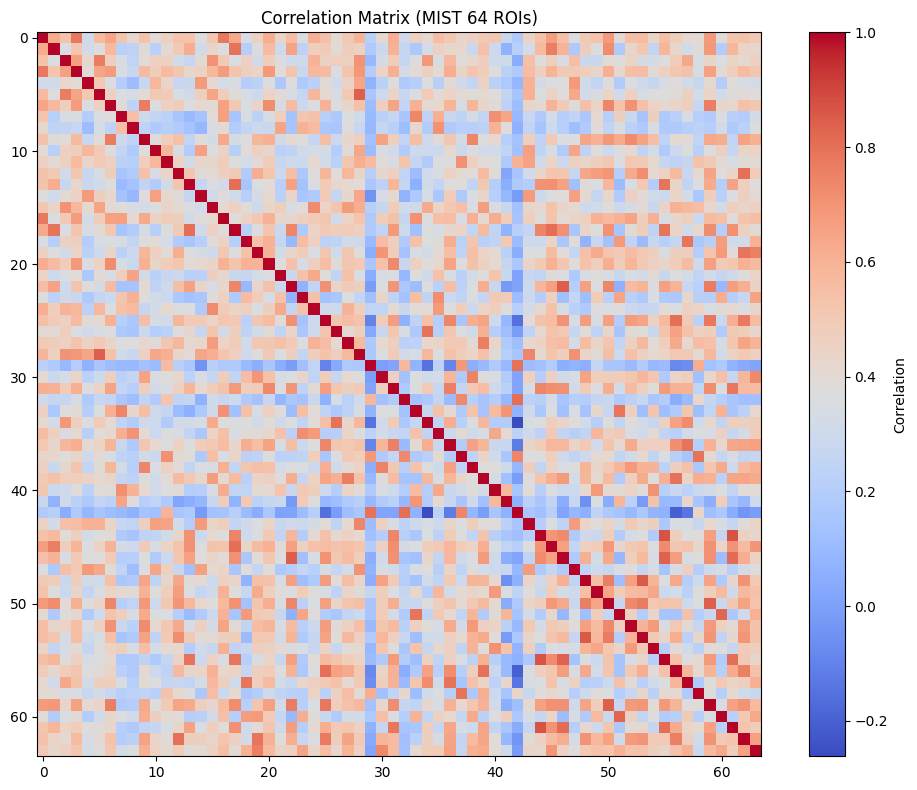


Plotting feature matrix...


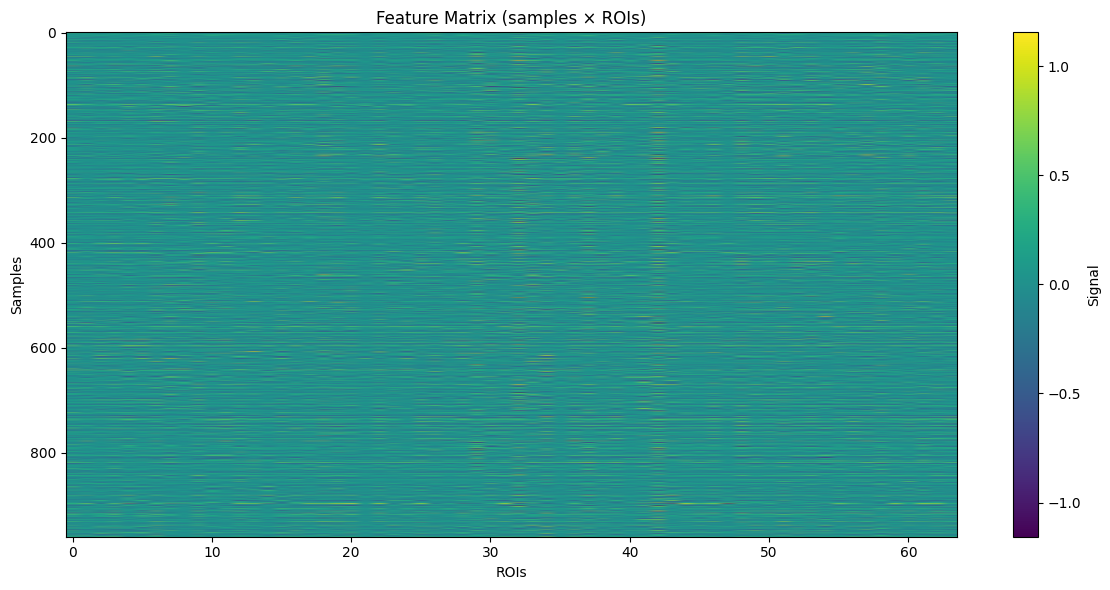


Test subjects held out: ['sub-11' 'sub-02' 'sub-12']

Starting GridSearchCV with StratifiedKFold on training data...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best parameters found: {'feature_selection__k': 10, 'svm__C': 10}
Best CV accuracy: 0.504

Training final model on full training set with best parameters...
Evaluating on test set...
Test accuracy on held-out subjects: 0.511


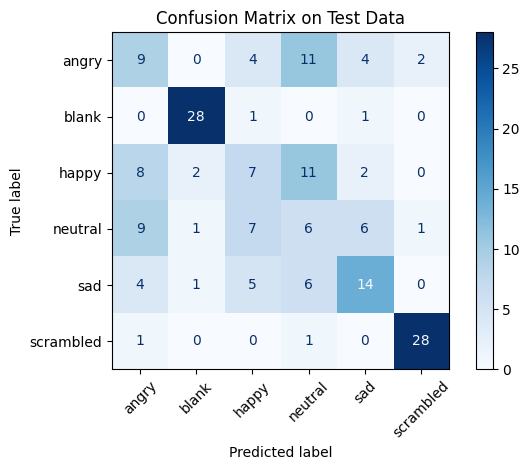

[CV] END ................feature_selection__k=5, svm__C=0.01; total time=   0.0s
[CV] END .................feature_selection__k=5, svm__C=0.1; total time=   0.0s
[CV] END ..................feature_selection__k=5, svm__C=10; total time=   0.0s
[CV] END ...............feature_selection__k=10, svm__C=0.01; total time=   0.0s
[CV] END ...............feature_selection__k=10, svm__C=0.01; total time=   0.0s
[CV] END ................feature_selection__k=10, svm__C=0.1; total time=   0.0s
[CV] END ..................feature_selection__k=10, svm__C=1; total time=   0.0s
[CV] END ..................feature_selection__k=10, svm__C=1; total time=   0.0s
[CV] END .................feature_selection__k=10, svm__C=10; total time=   0.0s
[CV] END .................feature_selection__k=10, svm__C=10; total time=   0.0s
[CV] END .................feature_selection__k=20, svm__C=10; total time=   0.1s
[CV] END .................feature_selection__k=20, svm__C=10; total time=   0.1s
[CV] END ..................f

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import datasets, image, masking, plotting, input_data, signal
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif
import joblib

# Configuration
FMRIPREP_DIR = "/home/ad3adha/ds003548-fmriprep"
EVENTS_DIR = "/home/ad3adha/ds003548"
CACHE_DIR = "mist64_cache"
TR = 2.0
N_RUNS = 5
TARGET_CONDITIONS = ["happy", "sad", "angry", "neutral", "scrambled", "blank"]
os.makedirs(CACHE_DIR, exist_ok=True)

#  Load MIST 64-ROI atlas
mist = datasets.fetch_atlas_basc_multiscale_2015()
mist64_path = mist['scale064']
masker = input_data.NiftiLabelsMasker(labels_img=mist64_path, standardize=True, detrend=True, t_r=TR)

# Subject list 
subjects = sorted([
    d for d in os.listdir(FMRIPREP_DIR)
    if d.startswith("sub-") and os.path.isdir(os.path.join(FMRIPREP_DIR, d))
])

# Load confounds
def load_confounds(subject, run):
    confound_path = os.path.join(
        FMRIPREP_DIR, subject, "func",
        f"{subject}_task-emotionalfaces_run-{run}_desc-confounds_timeseries.tsv"
    )
    df = pd.read_csv(confound_path, sep="\t")
    return df[["trans_x", "trans_y", "trans_z", "rot_x", "rot_y", "rot_z"]].fillna(0)

# Load and cache cleaned BOLD image
def get_cleaned_img(subject, run):
    cache_img_path = os.path.join(CACHE_DIR, f"{subject}_run-{run}_cleaned.nii.gz")
    if os.path.exists(cache_img_path):
        return image.load_img(cache_img_path)

    bold_path = os.path.join(
        FMRIPREP_DIR, subject, "func",
        f"{subject}_task-emotionalfaces_run-{run}_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz"
    )
    if not os.path.exists(bold_path):
        raise FileNotFoundError(f"Missing BOLD image for {subject} run {run}")

    confounds = load_confounds(subject, run)
    bold_img = image.load_img(bold_path)
    cleaned_data = signal.clean(
        bold_img.get_fdata().reshape(-1, bold_img.shape[-1]).T,
        confounds=confounds.values,
        t_r=TR,
        standardize=True,
        detrend=True,
    ).T
    cleaned_img = nib.Nifti1Image(cleaned_data.reshape(bold_img.shape), bold_img.affine)
    cleaned_img.to_filename(cache_img_path)
    return cleaned_img

# Load and cache features 
def extract_run_features(subject, run):
    cache_file = os.path.join(CACHE_DIR, f"{subject}_run-{run}_features.npz")
    if os.path.exists(cache_file):
        data = np.load(cache_file)
        return data["X"], data["y"]

    cleaned_img = get_cleaned_img(subject, run)

    events_path = os.path.join(EVENTS_DIR, f"task-emotionalfaces_run-{run}_events.tsv")
    if not os.path.exists(events_path):
        raise FileNotFoundError(f"Missing events for run {run}")

    events = pd.read_csv(events_path, sep="\t")
    events = events[events["trial_type"].isin(TARGET_CONDITIONS)]

    X, y = [], []
    for _, row in events.iterrows():
        onset = row["onset"]
        duration = row["duration"]
        label = row["trial_type"]
        start_vol = int(np.floor(onset / TR))
        end_vol = int(np.ceil((onset + duration) / TR))
        block = image.index_img(cleaned_img, slice(start_vol, end_vol))
        block_mean = image.mean_img(block)
        roi_ts = masker.fit_transform(block_mean)
        X.append(roi_ts[0])
        y.append(label)

    np.savez_compressed(cache_file, X=X, y=y)
    return np.array(X), np.array(y)

# Plot mean images per run (with caching check) 
def plot_mean_images_per_run():
    print("\nSaving mean images per run...")
    for subject in subjects:
        for run in range(1, N_RUNS + 1):
            out_path = f"mean_img_{subject}_run{run}.png"
            if os.path.exists(out_path):
                print(f"  Mean image plot for {subject} run {run} cached, skipping")
                continue
            bold_path = os.path.join(
                FMRIPREP_DIR, subject, "func",
                f"{subject}_task-emotionalfaces_run-{run}_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz"
            )
            if not os.path.exists(bold_path):
                continue
            try:
                mean_img = image.mean_img(bold_path)
                plotting.plot_epi(mean_img, title=f"{subject} Run {run}", output_file=out_path, display_mode="ortho", colorbar=True)
            except Exception as e:
                print(f"Error plotting {subject} run {run}: {e}")

# Main script 

# Extract features for all subjects and runs
X_all, y_all, run_ids = [], [], []
for subject in subjects:
    for run in range(1, N_RUNS + 1):
        try:
            X_run, y_run = extract_run_features(subject, run)
            X_all.append(X_run)
            y_all.append(y_run)
            run_ids.extend([(subject, run)] * len(y_run))
        except Exception as e:
            print(f"Skipping {subject}, run {run}: {e}")

X_all = np.vstack(X_all)
y_all = np.hstack(y_all)
run_ids = np.array(run_ids)

# Plot mean images per run
plot_mean_images_per_run()

# Visualize correlation matrix
print("\nPlotting ROI correlation matrix...")
corr_matrix = np.corrcoef(X_all.T)
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="Correlation")
plt.title("Correlation Matrix (MIST 64 ROIs)")
plt.tight_layout()
plt.show()

# Visualize feature matrix
print("\nPlotting feature matrix...")
plt.figure(figsize=(12, 6))
plt.imshow(X_all, aspect="auto", cmap="viridis")
plt.colorbar(label="Signal")
plt.title("Feature Matrix (samples × ROIs)")
plt.xlabel("ROIs")
plt.ylabel("Samples")
plt.tight_layout()
plt.show()

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y_all)

# Train/test split at subject level: hold out 3 subjects as test
rng = np.random.default_rng(seed=42)
test_subjects = rng.choice(subjects, 3, replace=False)
is_test = np.array([s in test_subjects for s, _ in run_ids])
X_train, X_test = X_all[~is_test], X_all[is_test]
y_train, y_test = y_enc[~is_test], y_enc[is_test]

print(f"\nTest subjects held out: {test_subjects}")

# Pipeline: scaling, feature selection, SVM
steps = [
    ("scaler", StandardScaler()),
    ("feature_selection", SelectKBest(f_classif)),
    ("svm", SVC(kernel="linear")),
]
clf = Pipeline(steps)

# Parameter grid for GridSearchCV
param_grid = {
    "feature_selection__k": [5, 10, 20, 35, 50, 64],
    "svm__C": [0.01, 0.1, 1, 10, 100],
}

# StratifiedKFold for CV within train data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nStarting GridSearchCV with StratifiedKFold on training data...")
grid = GridSearchCV(clf, param_grid, cv=cv, scoring="accuracy", n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

print(f"\nBest parameters found: {grid.best_params_}")
print(f"Best CV accuracy: {grid.best_score_:.3f}")

print("\nTraining final model on full training set with best parameters...")
best_clf = grid.best_estimator_
best_clf.fit(X_train, y_train)

print("Evaluating on test set...")
y_pred = best_clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy on held-out subjects: {test_acc:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=range(len(le.classes_)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix on Test Data")
plt.tight_layout()
plt.show()


In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

       angry       0.29      0.27      0.28        30
       happy       0.37      0.43      0.40        30
     neutral       0.32      0.40      0.36        30
         sad       0.30      0.20      0.24        30

    accuracy                           0.33       120
   macro avg       0.32      0.33      0.32       120
weighted avg       0.32      0.33      0.32       120



In [4]:
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

for i, class_name in enumerate(le.classes_):
    print(f"Accuracy for class '{class_name}': {per_class_accuracy[i]:.2f}")


Accuracy for class 'angry': 0.30
Accuracy for class 'blank': 0.93
Accuracy for class 'happy': 0.23
Accuracy for class 'neutral': 0.20
Accuracy for class 'sad': 0.47
Accuracy for class 'scrambled': 0.93


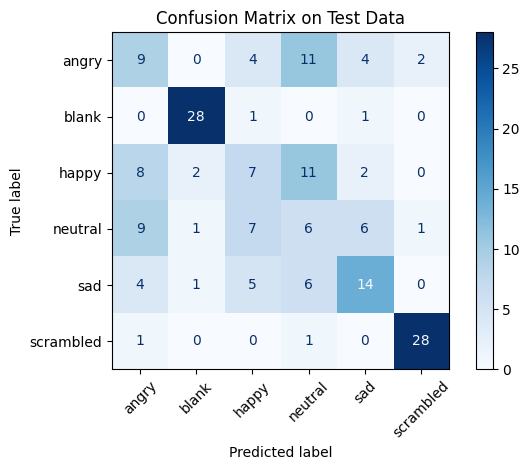

In [13]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=range(len(le.classes_)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix on Test Data")
plt.tight_layout()

# Save the plot to a file
plt.savefig("confusion_matrix_test.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()



Visualizing learned SVM weights...


/tmp/ipykernel_41617/1711098973.py:25: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  example_img = image.mean_img(get_cleaned_img(subjects[0], 1))


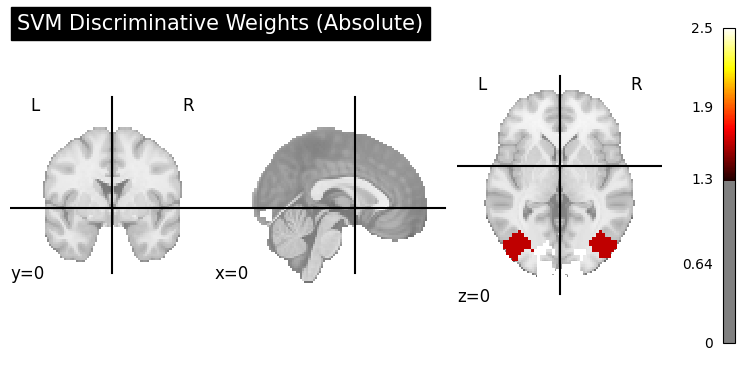


Top 10 discriminative ROIs (by weight):
ROI 42: weight = 2.5466
ROI 58: weight = 1.6140
ROI 56: weight = 1.2541
ROI 34: weight = 1.1295
ROI 37: weight = 0.9880
ROI 29: weight = 0.8255
ROI 36: weight = 0.7672
ROI 32: weight = 0.7309
ROI 11: weight = 0.5823
ROI 25: weight = 0.2861


In [18]:
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map

print("\nVisualizing learned SVM weights...")

# Get support mask from SelectKBest
selector = best_clf.named_steps["feature_selection"]
support_mask = selector.get_support()

# Get SVM weights
svm = best_clf.named_steps["svm"]
coefs = svm.coef_

# Average absolute weights across classes if multiclass
if coefs.shape[0] > 1:
    weights = np.mean(np.abs(coefs), axis=0)
else:
    weights = np.abs(coefs[0])

# Reconstruct full-length weight vector (length = 64)
all_weights = np.zeros(64)
all_weights[support_mask] = weights

# Refit masker on a representative image
example_img = image.mean_img(get_cleaned_img(subjects[0], 1))
masker.fit(example_img)

# Inverse transform to image space
weight_img = masker.inverse_transform([all_weights])


# Save image
weight_img.to_filename("svm_roi_weight_map.nii.gz")

# Plot image
plot_stat_map(
    weight_img,
    title="SVM Discriminative Weights (Absolute)",
    display_mode="ortho",
    threshold=np.percentile(weights, 80),  # top 20%
    cmap="cold_hot",
    cut_coords=(0, 0, 0),
)
plt.show()

# Optionally: print top-weighted ROIs
print("\nTop 10 discriminative ROIs (by weight):")
top_indices = np.argsort(-all_weights)[:10]
for i in top_indices:
    print(f"ROI {i}: weight = {all_weights[i]:.4f}")


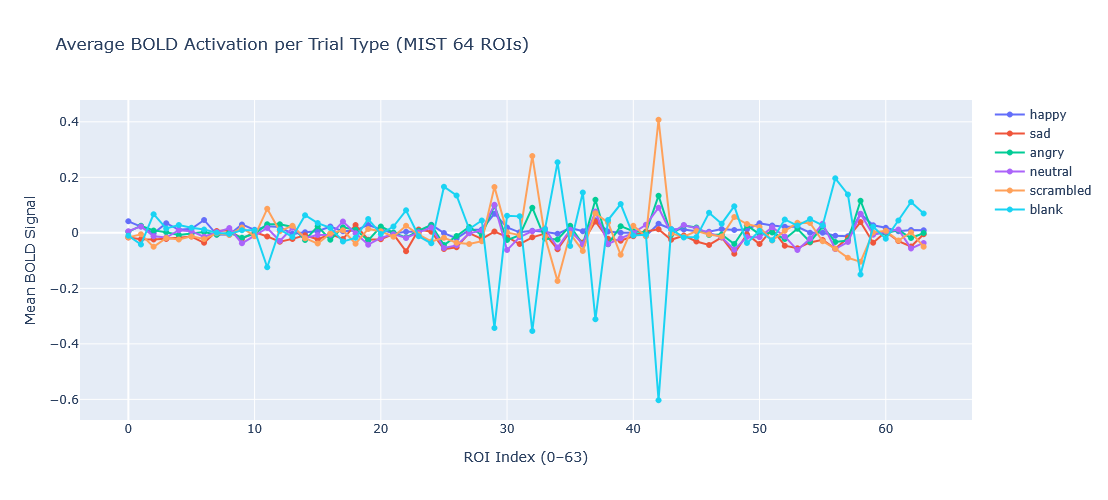

In [ ]:
import plotly.graph_objects as go
from collections import defaultdict

 # Aggregate ROI activations per trial type 
trial_data = defaultdict(list)

# Re-map encoded labels back to original trial_type
y_labels = le.inverse_transform(y_enc)

for x, label in zip(X_all, y_labels):
    trial_data[label].append(x)

#  Compute mean activation per trial type 
avg_data = {
    label: np.mean(np.vstack(acts), axis=0)
    for label, acts in trial_data.items()
}

# Interactive plot using Plotly 
fig = go.Figure()

for label in TARGET_CONDITIONS:
    if label in avg_data:
        fig.add_trace(go.Scatter(
            x=list(range(len(avg_data[label]))),
            y=avg_data[label],
            mode="lines+markers",
            name=label,
            hoverinfo="name+y",
        ))

fig.update_layout(
    title="Average BOLD Activation per Trial Type (MIST 64 ROIs)",
    xaxis_title="ROI Index (0–63)",
    yaxis_title="Mean BOLD Signal",
    hovermode="closest",
    width=900,
    height=500
)

fig.show()
fig.write_html("average_bold_activation.html")



/home/ad3adha/datalad-env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning:





Interactive plot for 'happy':



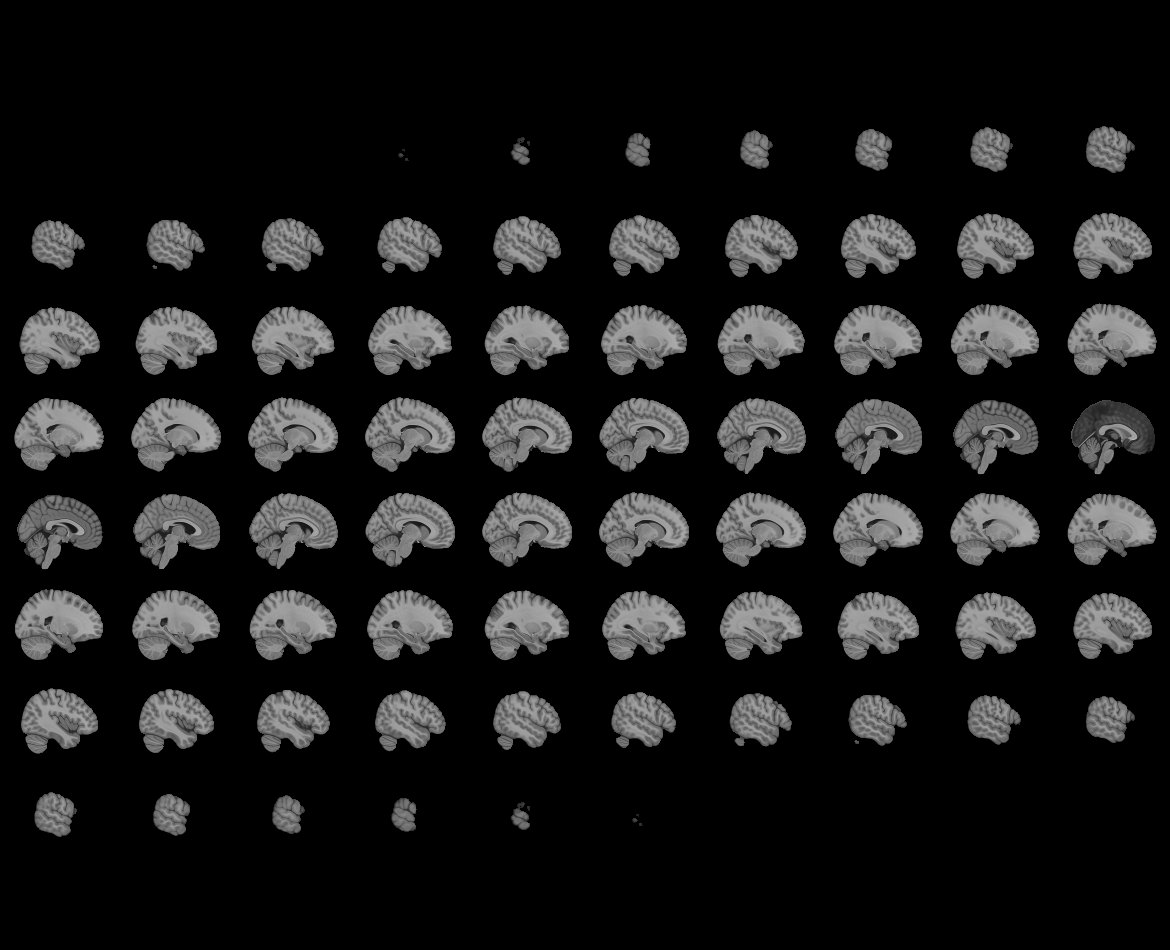
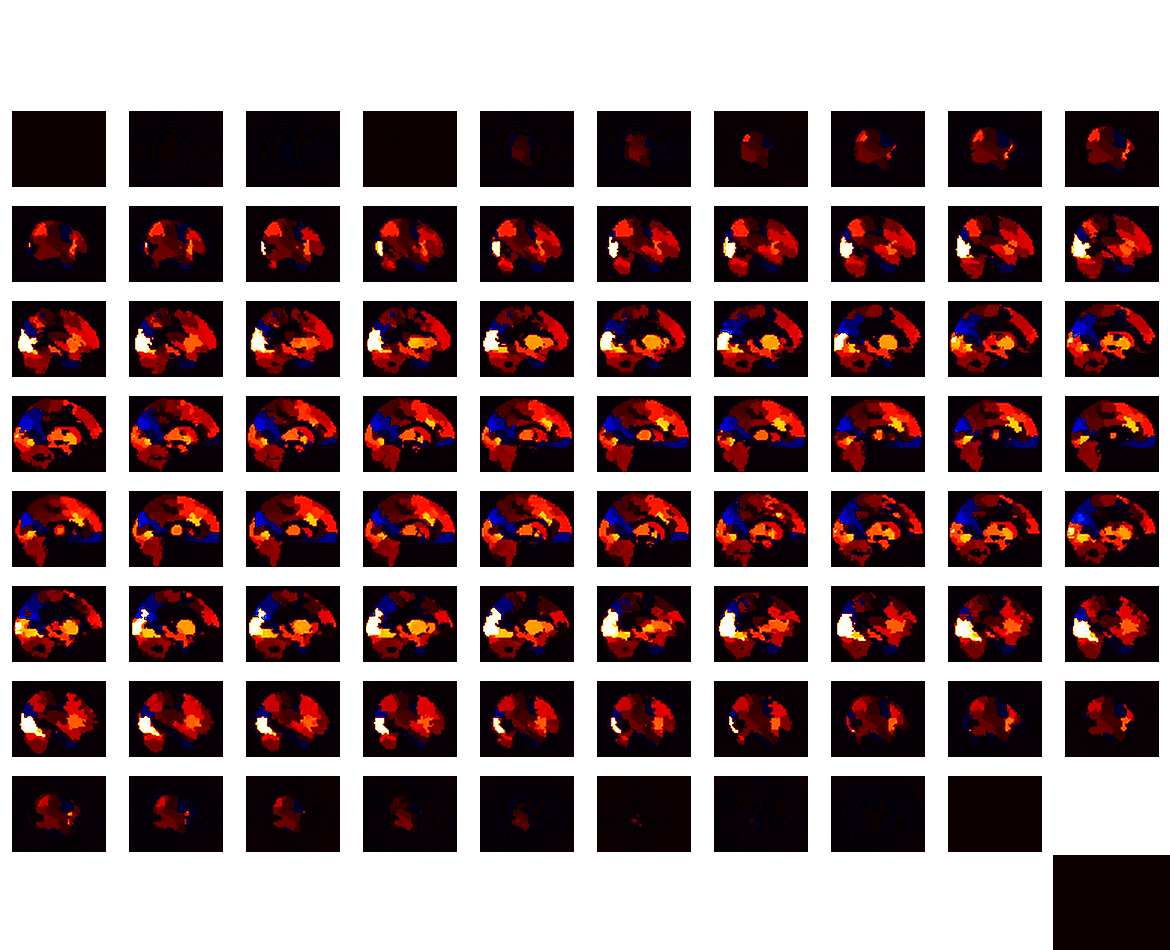

/home/ad3adha/datalad-env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning:





Interactive plot for 'sad':



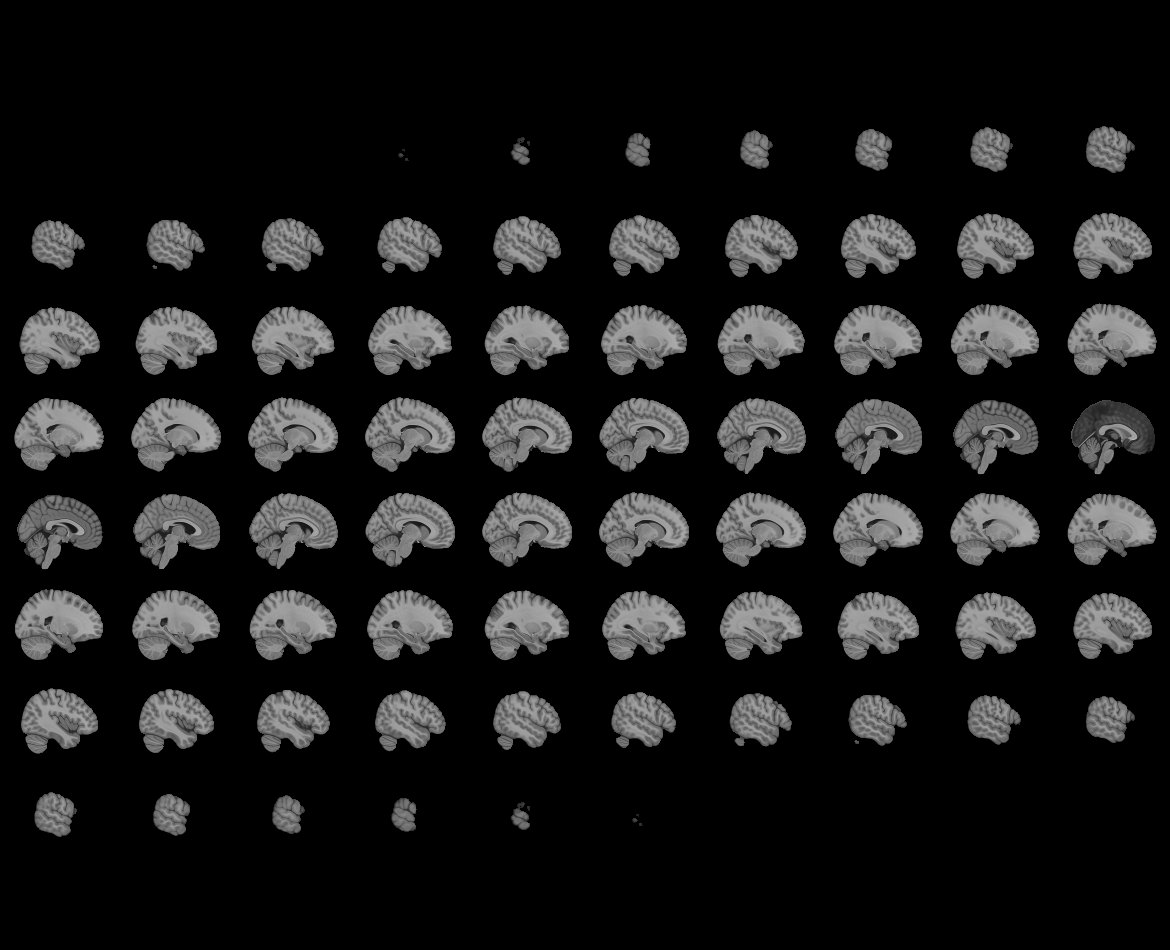
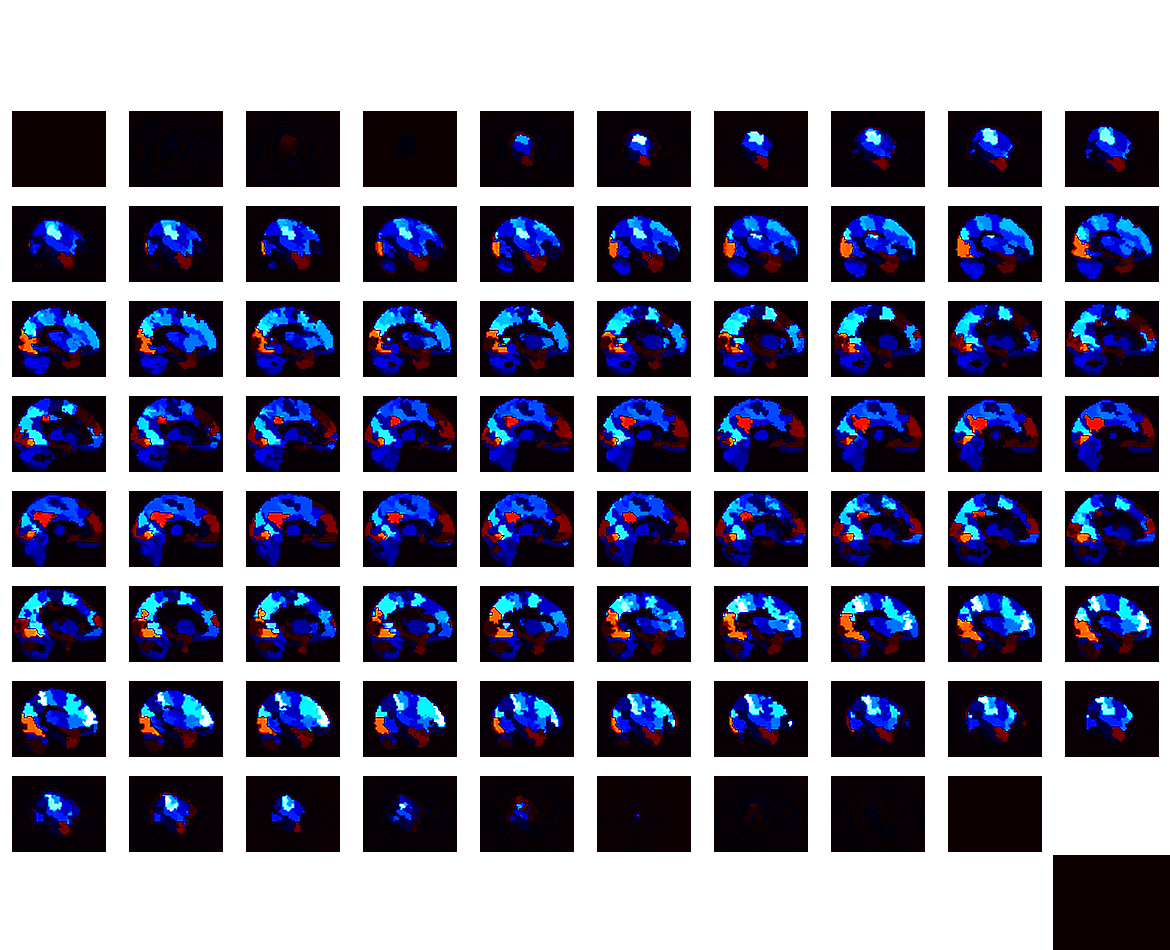

/home/ad3adha/datalad-env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning:





Interactive plot for 'angry':



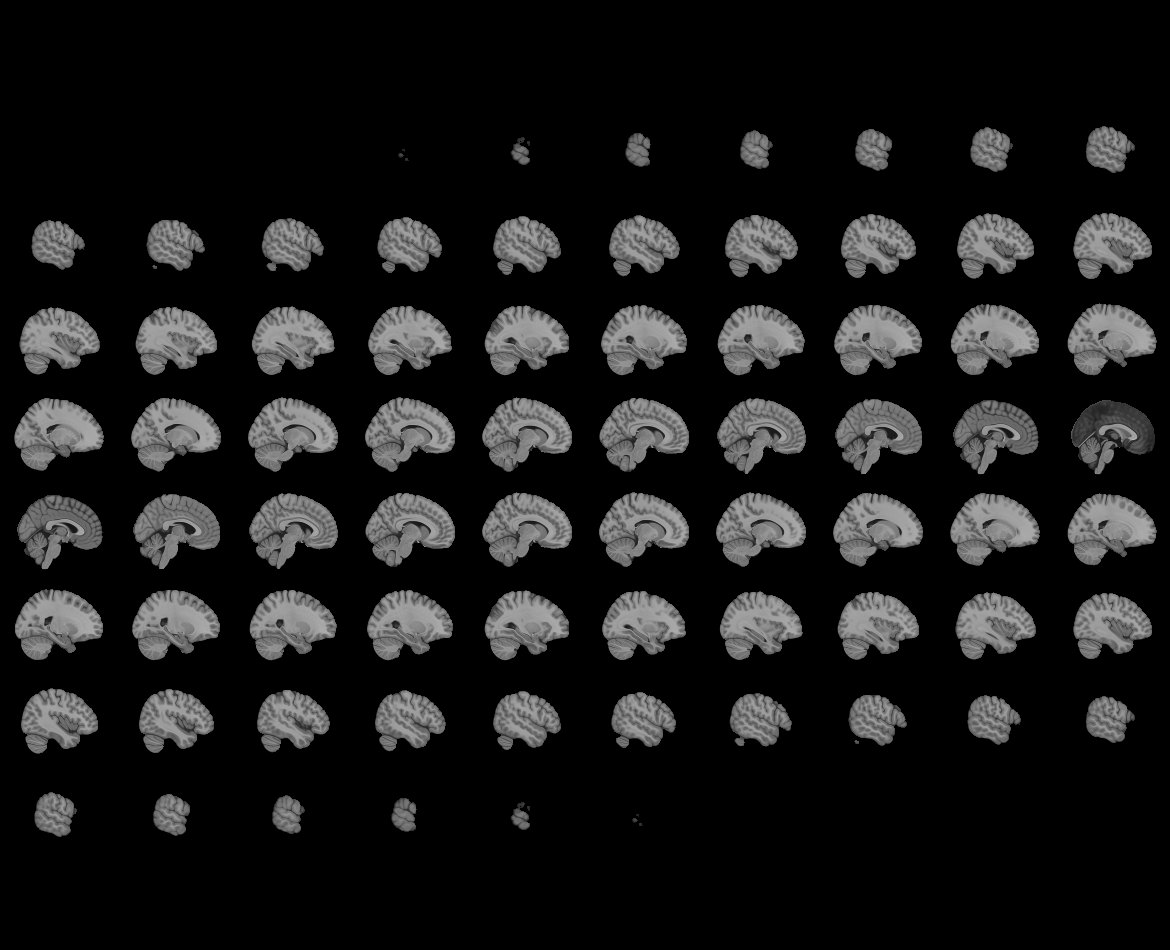
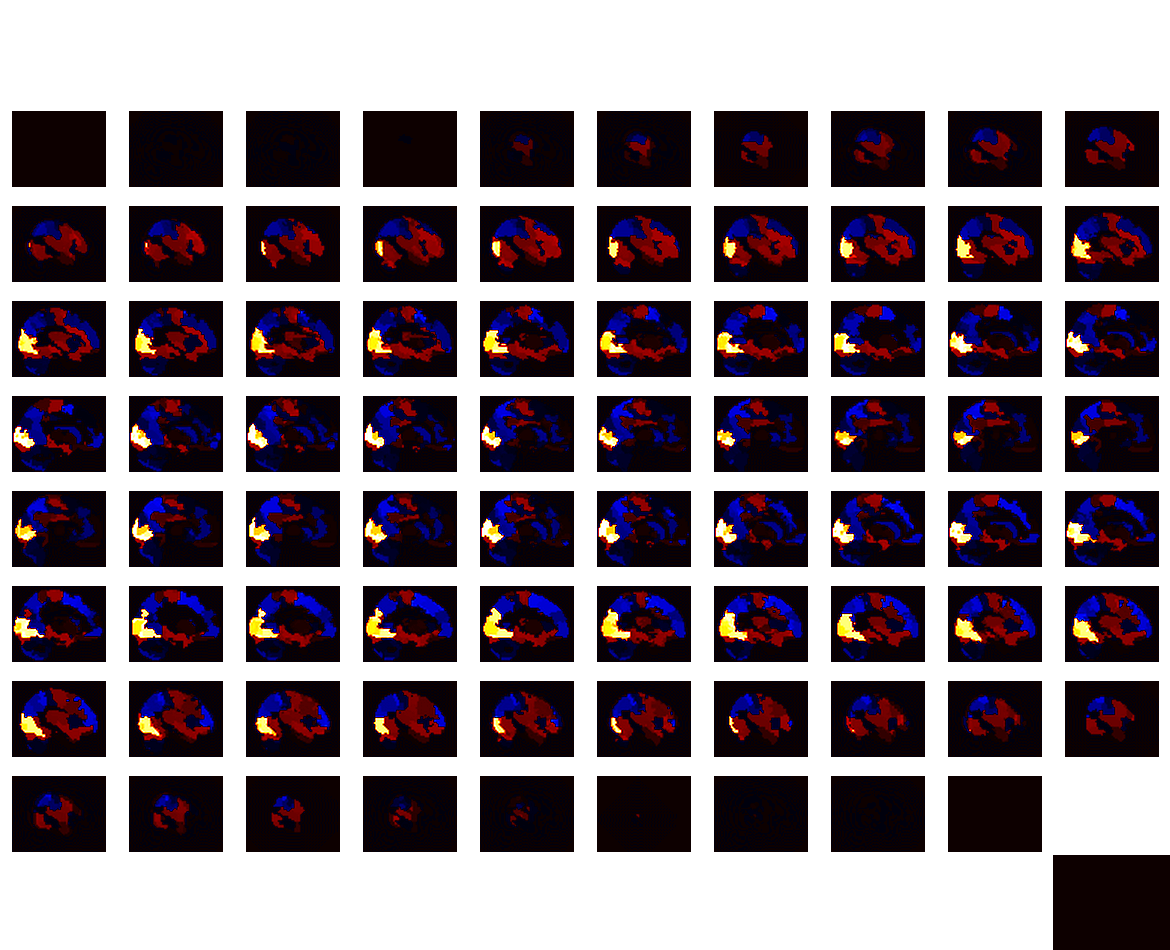

/home/ad3adha/datalad-env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning:





Interactive plot for 'neutral':



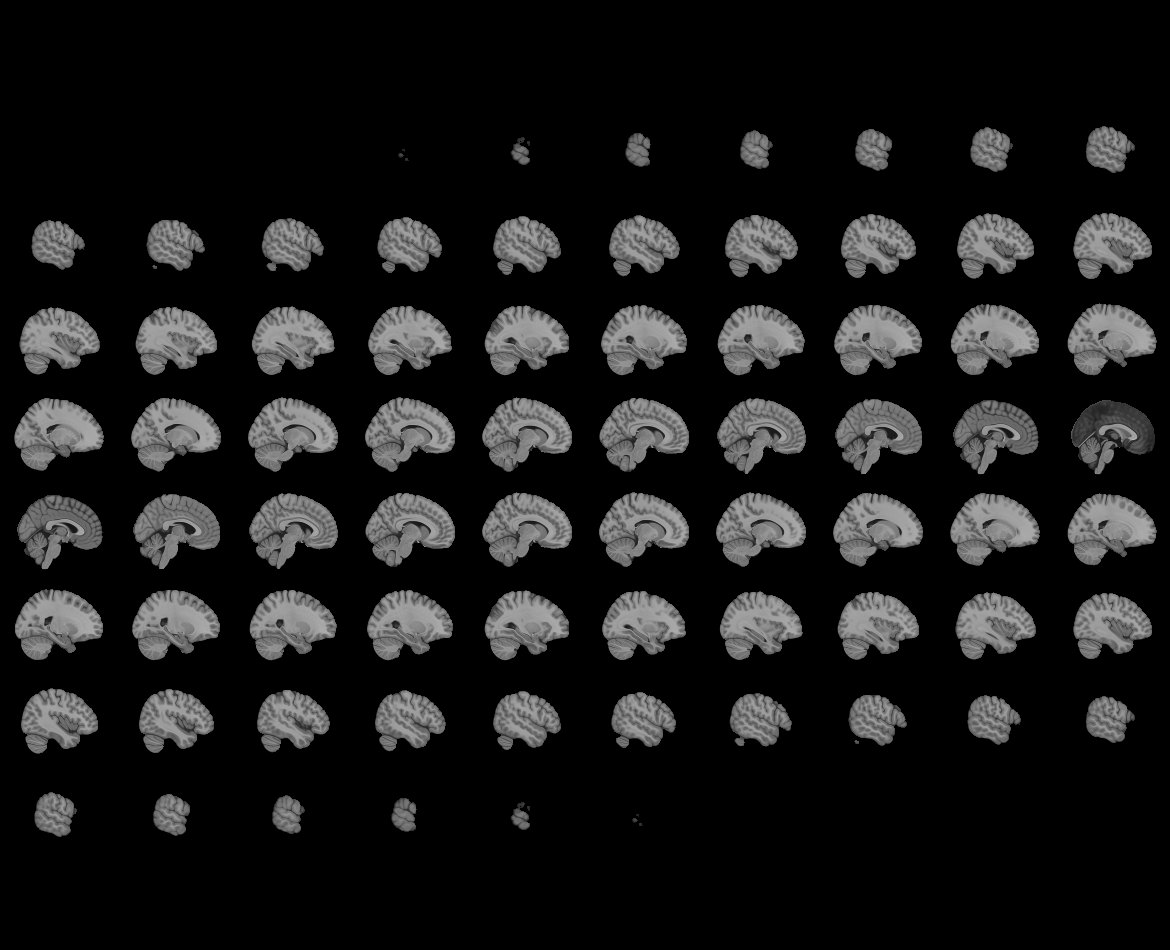
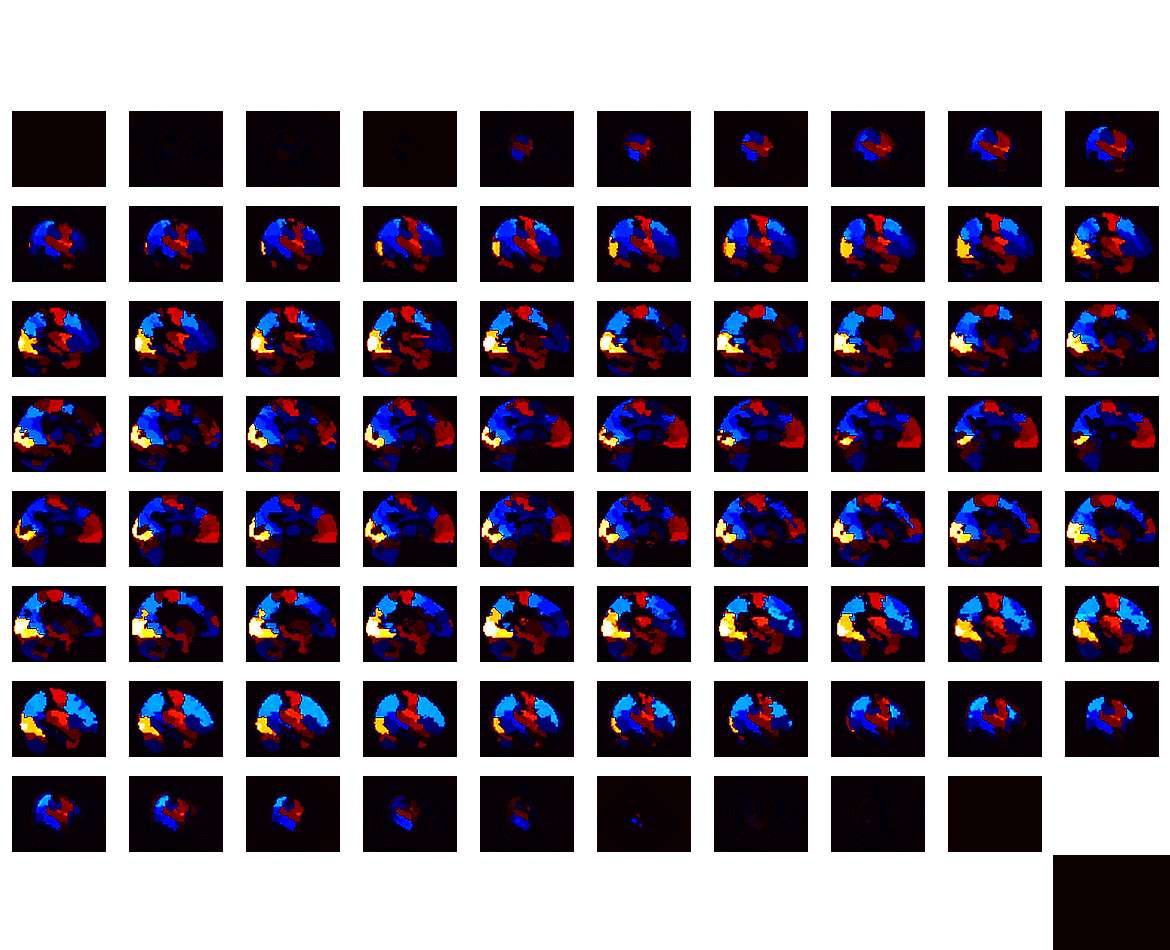

/home/ad3adha/datalad-env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning:





Interactive plot for 'scrambled':



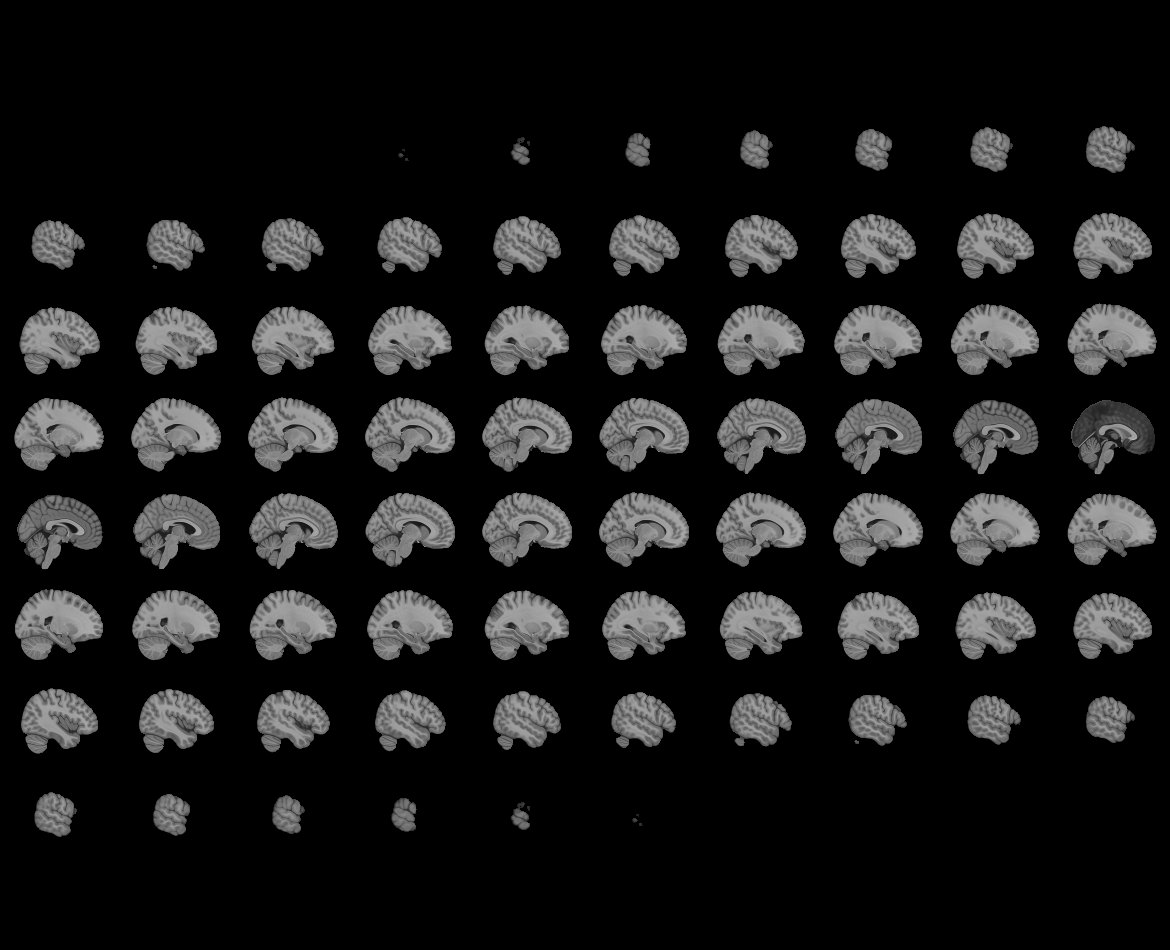
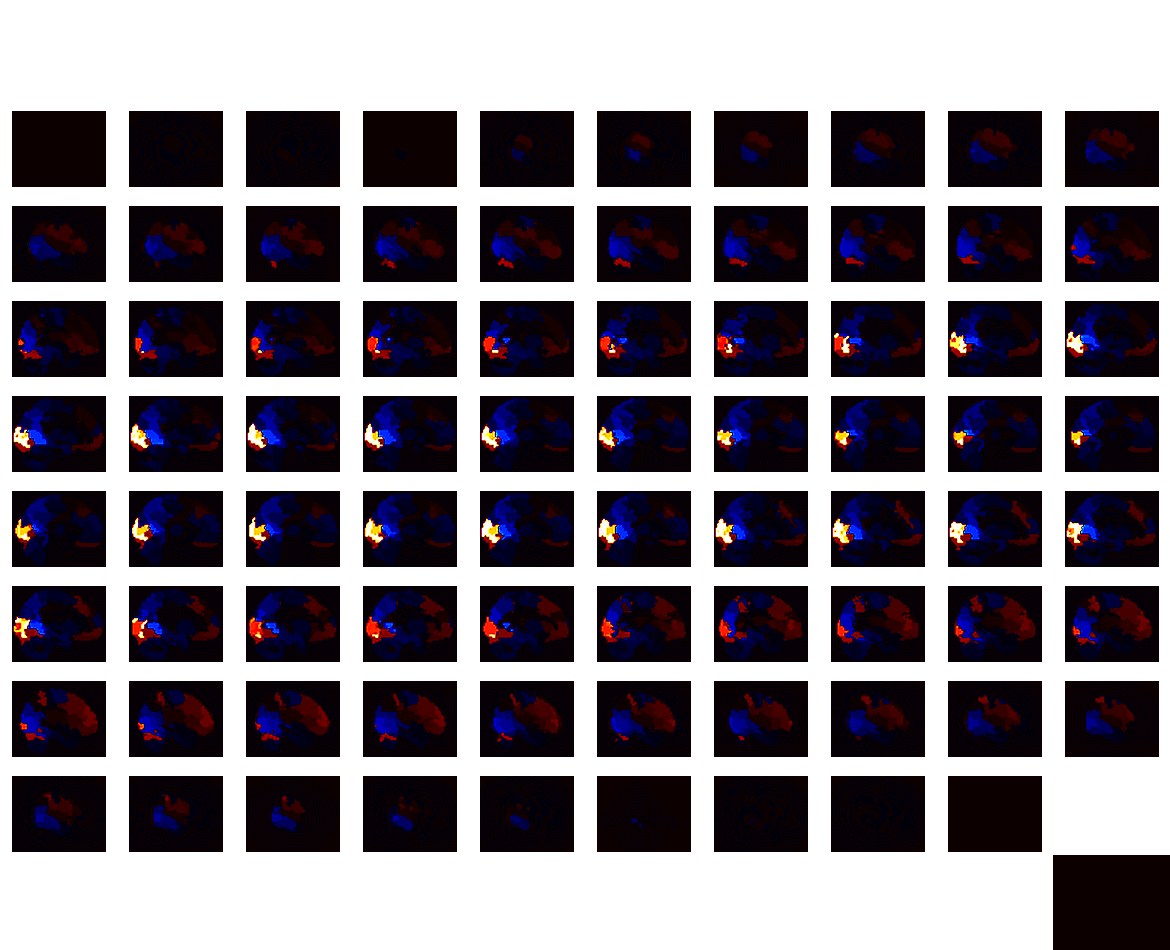

/home/ad3adha/datalad-env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning:





Interactive plot for 'blank':



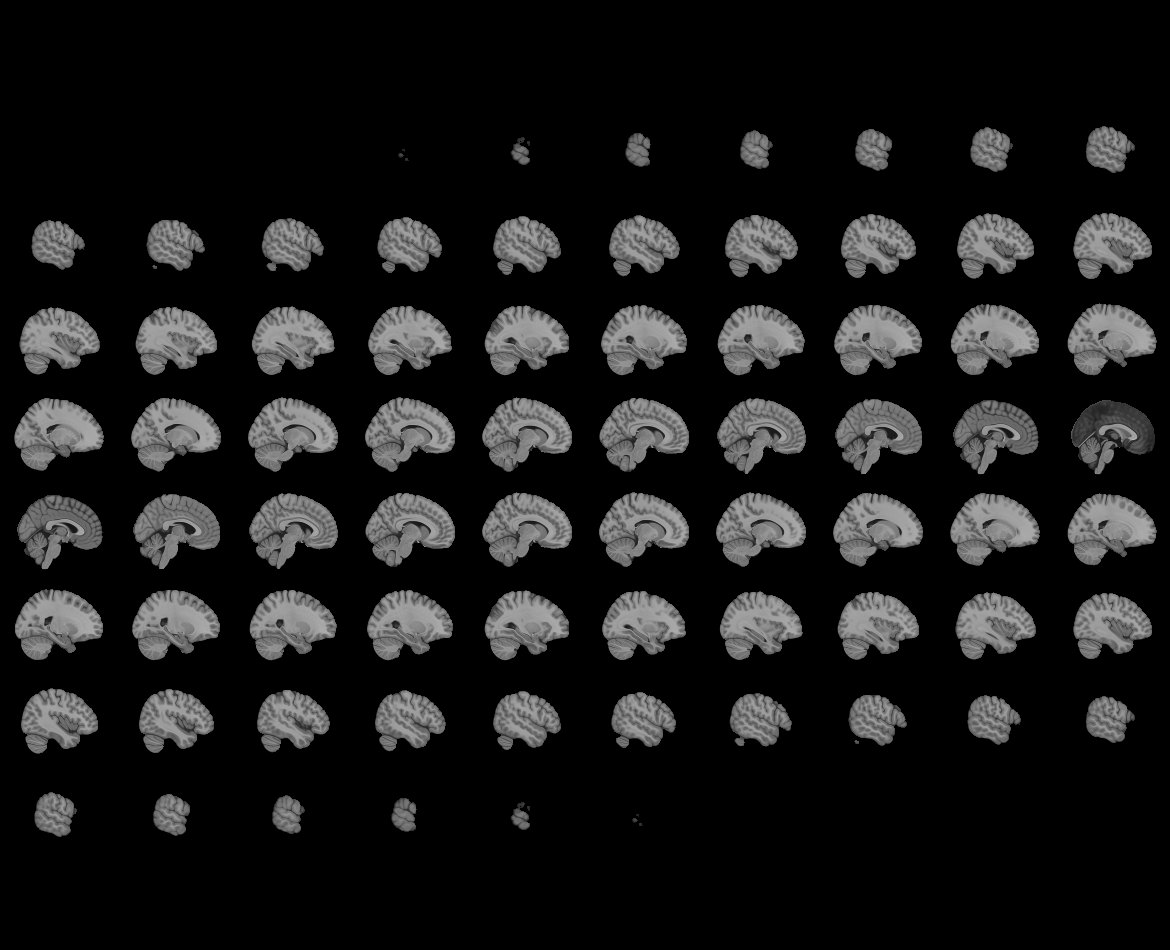
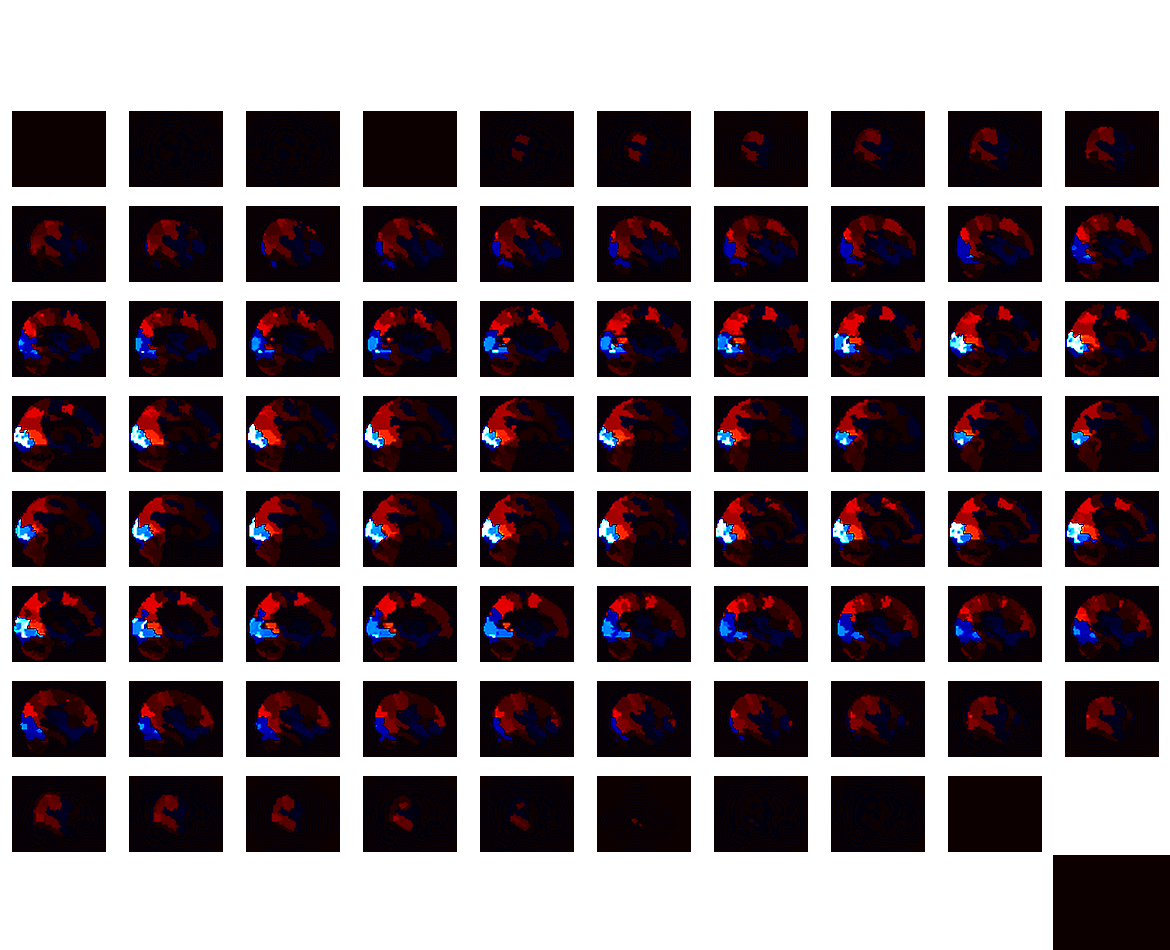

In [ ]:
from nilearn.plotting import view_img
from IPython.display import display

# Rebuild average images per trial type
for label in TARGET_CONDITIONS:
    if label in avg_data:
        avg_vector = avg_data[label]
        avg_img = masker.inverse_transform(avg_vector)
        interactive_plot = view_img(avg_img, title=f"Average Activation: {label}", threshold=None)
        print(f"\nInteractive plot for '{label}':")
        display(interactive_plot)


In [ ]:
import ipywidgets as widgets
from IPython.display import display
from nilearn.plotting import view_img

# Compute average activation maps per trial type
avg_imgs = {}
for label in TARGET_CONDITIONS:
    if label in avg_data:
        avg_vector = avg_data[label]
        avg_imgs[label] = masker.inverse_transform(avg_vector)

# Interactive tabbed viewer
def create_view(label):
    return view_img(avg_imgs[label], title=f"Average Activation: {label}", threshold=None)

dropdown = widgets.Dropdown(
    options=TARGET_CONDITIONS,
    description='Trial Type:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

output = widgets.Output()

def update_plot(change):
    with output:
        output.clear_output()
        display(create_view(change.new))

dropdown.observe(update_plot, names='value')

# Initial display
with output:
    display(create_view(dropdown.value))

display(dropdown, output)

import os

# Output directory
output_dir = "avg_activation_html"
os.makedirs(output_dir, exist_ok=True)

# Save each interactive viewer as an HTML file
for label, img in avg_imgs.items():
    viewer = view_img(img, title=f"Average Activation: {label}", threshold=None)
    html_path = os.path.join(output_dir, f"avg_activation_{label}.html")
    viewer.save_as_html(html_path)
    print(f"Saved: {html_path}")



Dropdown(description='Trial Type:', layout=Layout(width='50%'), options=('happy', 'sad', 'angry', 'neutral', '…

Output()

/home/ad3adha/datalad-env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning:




Saved: avg_activation_html/avg_activation_happy.html


/home/ad3adha/datalad-env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning:




Saved: avg_activation_html/avg_activation_sad.html


/home/ad3adha/datalad-env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning:




Saved: avg_activation_html/avg_activation_angry.html


/home/ad3adha/datalad-env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning:




Saved: avg_activation_html/avg_activation_neutral.html


/home/ad3adha/datalad-env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning:




Saved: avg_activation_html/avg_activation_scrambled.html


/home/ad3adha/datalad-env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning:




Saved: avg_activation_html/avg_activation_blank.html


In [28]:
index_path = os.path.join(output_dir, "index.html")
with open(index_path, "w") as f:
    f.write("<h1>Average BOLD Activation Maps</h1><ul>\n")
    for label in TARGET_CONDITIONS:
        html_file = f"avg_activation_{label}.html"
        f.write(f'<li><a href="{html_file}" target="_blank">{label}</a></li>\n')
    f.write("</ul>")
print(f"Index page saved at: {index_path}")


Index page saved at: avg_activation_html/index.html


In [29]:
import os
from nilearn import plotting

# Directory to save static images
static_img_dir = "static_activation_maps"
os.makedirs(static_img_dir, exist_ok=True)

for label, img in avg_imgs.items():
    out_path = os.path.join(static_img_dir, f"avg_activation_{label}.png")
    print(f"Saving static image for {label} at {out_path} ...")
    display = plotting.plot_stat_map(
        img, 
        title=f"Average Activation: {label}", 
        threshold=None,
        display_mode="ortho", 
        cut_coords=(0, 0, 0),  # you can customize this to a more informative coordinate
        colorbar=True
    )
    display.savefig(out_path)
    display.close()


Saving static image for happy at static_activation_maps/avg_activation_happy.png ...
Saving static image for sad at static_activation_maps/avg_activation_sad.png ...
Saving static image for angry at static_activation_maps/avg_activation_angry.png ...
Saving static image for neutral at static_activation_maps/avg_activation_neutral.png ...
Saving static image for scrambled at static_activation_maps/avg_activation_scrambled.png ...
Saving static image for blank at static_activation_maps/avg_activation_blank.png ...


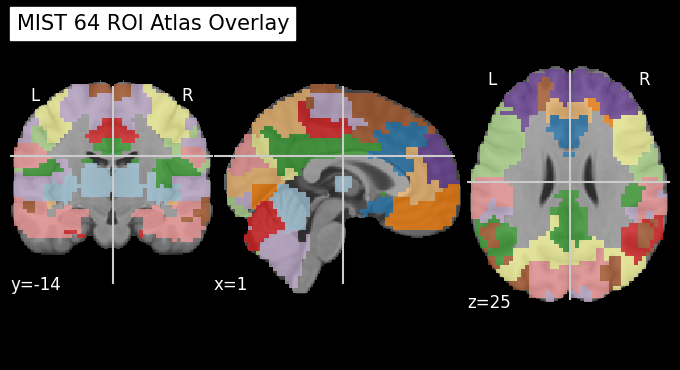

In [30]:
from nilearn import plotting

# Plot MIST 64 ROI atlas over a brain template
template = datasets.load_mni152_template()
atlas_img = mist64_path  # from your earlier code

fig = plt.figure(figsize=(8, 6))
display = plotting.plot_roi(atlas_img, bg_img=template,
                           title="MIST 64 ROI Atlas Overlay",
                           cmap='Paired', alpha=0.7)
plt.savefig("mist64_roi_overlay.png", dpi=150)
plt.close(fig)


In [31]:
import seaborn as sns

corr_matrix = np.corrcoef(X_all.T)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', square=True, cbar_kws={'label': 'Correlation'})
plt.title("Correlation Matrix (MIST 64 ROIs)")
plt.tight_layout()
plt.savefig("roi_correlation_matrix.png", dpi=150)
plt.close()


In [32]:
plt.figure(figsize=(12, 6))
sns.heatmap(X_all, cmap="viridis", cbar_kws={'label': 'Signal'}, xticklabels=False, yticklabels=False)
plt.title("Feature Matrix (samples × ROIs)")
plt.xlabel("ROIs")
plt.ylabel("Samples")
plt.tight_layout()
plt.savefig("feature_matrix_heatmap.png", dpi=150)
plt.close()


In [33]:
import pandas as pd

results = pd.DataFrame(grid.cv_results_)

# Pivot table for heatmap: mean test score by feature_selection__k and svm__C
pivot_table = results.pivot(index='param_feature_selection__k', columns='param_svm__C', values='mean_test_score')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("GridSearchCV Accuracy")
plt.xlabel("SVM C")
plt.ylabel("Number of Features (k)")
plt.tight_layout()
plt.savefig("gridsearchcv_accuracy_heatmap.png", dpi=150)
plt.close()


In [34]:
import matplotlib.pyplot as plt

# Collect accuracy per test subject
subject_acc = {}
for subj in test_subjects:
    subj_mask = np.array([s == subj for s, _ in run_ids[is_test]])
    if np.any(subj_mask):
        subj_y_true = y_enc[is_test][subj_mask]
        subj_y_pred = y_pred[subj_mask]
        acc = accuracy_score(subj_y_true, subj_y_pred)
        subject_acc[subj] = acc

plt.figure(figsize=(7, 5))
plt.bar(subject_acc.keys(), subject_acc.values(), color='skyblue')
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.xlabel("Test Subject")
plt.title("Test Accuracy per Subject")
plt.tight_layout()
plt.savefig("test_accuracy_per_subject.png", dpi=150)
plt.close()


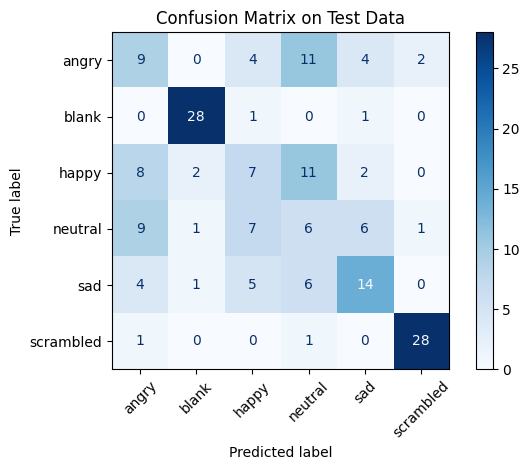

[CV] END ................feature_selection__k=5, svm__C=0.01; total time=   0.0s
[CV] END ...................feature_selection__k=5, svm__C=1; total time=   0.0s
[CV] END ..................feature_selection__k=5, svm__C=10; total time=   0.0s
[CV] END .................feature_selection__k=5, svm__C=100; total time=   0.1s
[CV] END ...............feature_selection__k=20, svm__C=0.01; total time=   0.0s
[CV] END ...............feature_selection__k=20, svm__C=0.01; total time=   0.0s
[CV] END ................feature_selection__k=20, svm__C=0.1; total time=   0.0s
[CV] END ................feature_selection__k=20, svm__C=0.1; total time=   0.0s
[CV] END .................feature_selection__k=20, svm__C=10; total time=   0.1s
[CV] END .................feature_selection__k=20, svm__C=10; total time=   0.1s
[CV] END ..................feature_selection__k=35, svm__C=1; total time=   0.0s
[CV] END ..................feature_selection__k=35, svm__C=1; total time=   0.0s
[CV] END .................fe

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = y_test
y_pred = best_clf.predict(X_test)  # ✅ Use best_clf, not clf

cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_enc))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix on Test Data")
plt.tight_layout()
plt.show()
